# Expérimentation sur le filtre de Kalman sans parfum

Ces expérimentations sont tirées de : https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python (Chapitre 10).

In [1]:
%matplotlib inline

Pour exécuter la cellule suivante il faut que le fichier *book_format.py* et le répertoire *kf_book* soient dans votre répertoire de travail.

In [2]:
import book_format
book_format.set_style()

Pour réaliser les expériences vous devez installer la bibliothèque *FilterPy*.
Voir : https://anaconda.org/conda-forge/filterpy

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/kf_book/nonlinear_plots.py

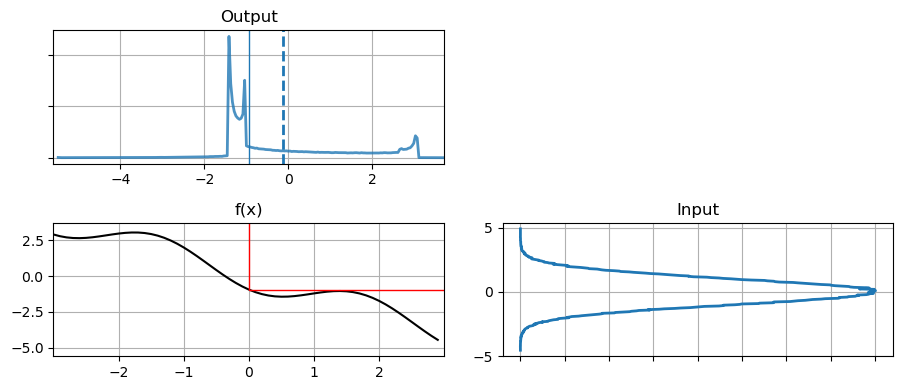

In [3]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from scipy.stats import norm
import numpy as np

# create 500, 000 samples with mean 0, std 1
gaussian = (0., 1.)
nbSamples = 500000
data = norm.rvs(loc = gaussian[0], scale = gaussian[1], size = nbSamples)

def f(x):
    return (np.cos(4 * (x / 2 + 0.7))) - 1.3 * x

plot_nonlinear_func(data, f)

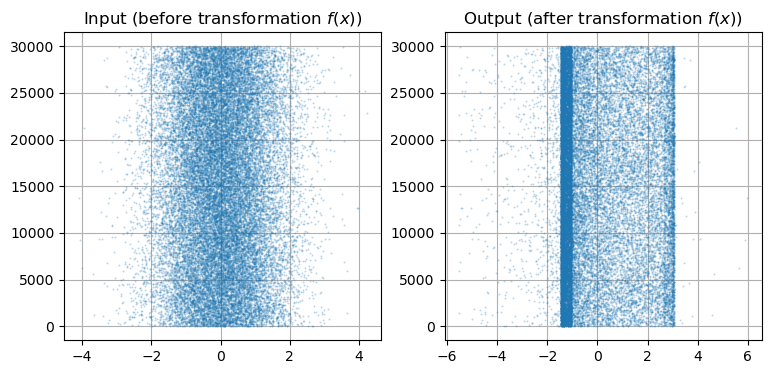

In [4]:
nbrSamples = 30000
plt.subplot(121)
plt.scatter(data[:nbrSamples], range(nbrSamples), alpha = 0.2, s = 1)
plt.title('Input (before transformation $f(x)$)')
plt.subplot(122)
plt.title('Output (after transformation $f(x)$)')
plt.scatter(f(data[:nbrSamples]), range(nbrSamples), alpha = 0.2, s = 1)
plt.show()

Let's consider the 1D-Tracking problem gouverns by the following state space model:
$$
    \begin{bmatrix}
        x_{k+1} \\
        \dot{x}_{k+1}
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & \Delta t \\
        0 & 1
    \end{bmatrix}
    \begin{bmatrix}
        x_{k} \\
        \dot{x}_{k}
    \end{bmatrix}
    +
    v_k
    \\
    z_k
    =
    \begin{bmatrix}
        1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        x_{k} \\
        \dot{x}_{k}
    \end{bmatrix}
    +
    w_k
$$
The state vector is defined by the position $x_k$ and the velocity $\dot{x}_{k}$ and $\Delta t$ the sampling period.

The following paper described an algorithme to compute the sigma points.

Simon J. Julier and Jeffrey K. Uhlmann. *New extension of the Kalman filter to nonlinear systems*. Proceedings of SPIE, Vol 3068, N° 1, pp. 182-193, 1997.

In [5]:
import os
os.system('open UKF1.pdf')

0

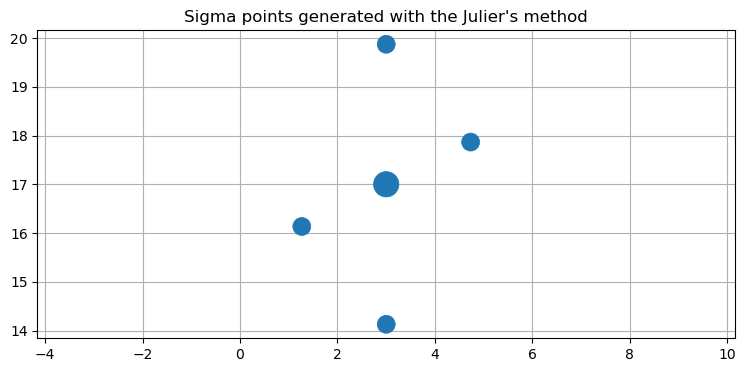

In [6]:
from filterpy.kalman import JulierSigmaPoints
from kf_book.ukf_internal import plot_sigmas
sigmaPoints = JulierSigmaPoints(n = 2, kappa = 1)
plt.title('Sigma points generated with the Julier\'s method')
plot_sigmas(sigmaPoints, x = [3, 17], cov = [[1, 0.5], [0.5, 3]])

In [7]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

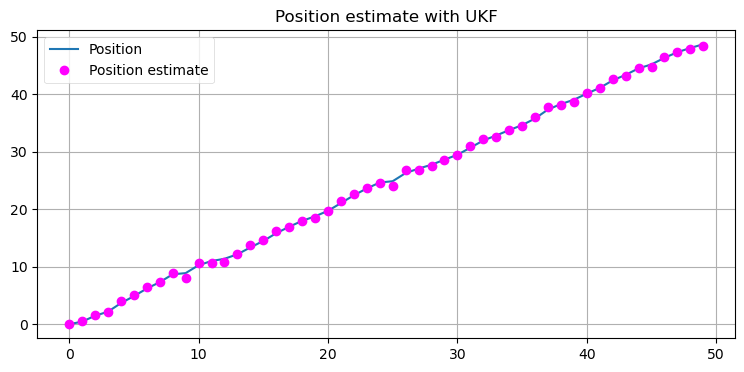

In [8]:
from scipy.stats import norm
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x = 2, dim_z = 1, dt = 1.0, hx = hx, fx = fx, points = sigmaPoints)
ukf.P = ukf.P * 10
ukf.R = ukf.R * 0.5
ukf.Q = Q_discrete_white_noise(dim = 2, dt = 1.0, var = 0.03)

zs, xs = [], []
for i in range(50):
    z = norm.rvs(loc = i, scale = 0.5, size = 1)
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs, label = 'Position')
plt.plot(zs, marker = 'o', ls = '', color = 'magenta', label = 'Position estimate')
plt.title('Position estimate with UKF')
plt.legend()
plt.show()

The following paper described another algorithm to compute the sigma points.

Wan E., Van Der Merwe R. *The unscented Kalman filter for nonlinear estimation*. In: Proceedings of the IEEE 2000 Adaptive Systems for Signal Processing, Communications, and Control Symposium (Cat. No.00EX373). IEEE; 2000:153-158. doi:10.1109/ASSPCC.2000.882463

In [9]:
import os
os.system('open UKF2.pdf')

0

In [10]:
def f_nonlinear_xy(x, y):
    return np.array([x + y, 0.1 * x ** 2 + y * y])

Difference in mean x=-0.097, y=0.549


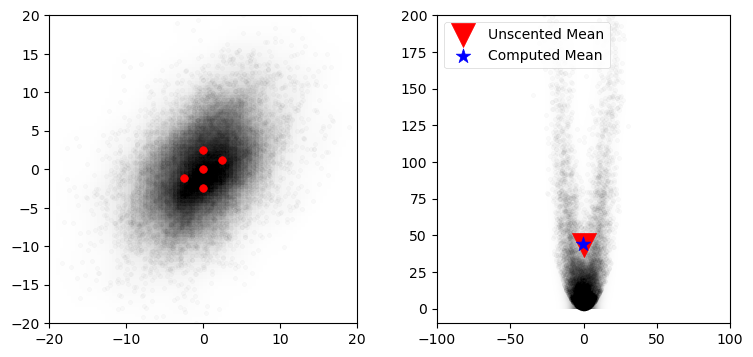

In [11]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmaPoints = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmaPoints[i, 0], sigmaPoints[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmaPoints[:,0], sigmaPoints[:,1], c='r', s=30);

![title]("UKF1.pdf")

## Using the UKF

We will consider a linear problem you already know how to solve with the linear Kalman filter. Although the UKF was designed for nonlinear problems, it finds the same optimal result as the linear Kalman filter for linear problems. We will write a filter to track an object in 2D using a constant velocity model.

\begin{equation}
		\left\{
			\begin{array}{l}
				x_{k+1} = F x_k +C u + G v_k \\
				z_k = H x_k + w_k
			\end{array}
		\right.
\end{equation}

$u_t \in \mathbb{R}^n$ : a known input, $v_t \in \mathbb{R}^{\ell}$ : gaussian state noise, $w_t \in \mathbb{R}^p$ : gaussian measurement noise.

$v_t$ et $w_t$ are white noise whose correlation matrix are:	
\begin{equation}
	\left\{
		\begin{array}{l}
			\mathbb{E}[v_i v_j^T] = \delta_{ij}Q_i \\
			\mathbb{E}[w_i w_j^T] = \delta_{ij}R_i \\
			\mathbb{E}[v_i w_j^T] = 0
		\end{array}
	\right.
\end{equation}

$x_0 \sim \mathcal{N}(\hat{x}_0,P_{0\vert0})$ is independent from the noises $v_t$ et $w_t$.


We want a constant velocity model, so we define $\bf{x}$ from the Newtonian equations:

$$
\begin{aligned}
    x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
    y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}
$$


$$
\mathbf{x} = \begin{bmatrix}
                x \\
                \dot{x} \\
                y \\
                \dot{y}
             \end{bmatrix}
$$

With this ordering of state variables the state transition matrix is

$$
\mathbf{F} = \begin{bmatrix}
                1 & \Delta t & 0 & 0 \\
                0 & 1& 0 & 0 \\
                0 & 0 & 1 & \Delta t\\
                0 & 0 & 0 & 1
             \end{bmatrix}
$$

Our sensors provide position but not velocity, so the measurement function is

$$
\mathbf{H} = \begin{bmatrix}
                1 & 0 & 0 & 0 \\
                0 & 0 & 1 & 0
\end{bmatrix}
$$

The sensor readings are in meters with an error of $\sigma=0.3$ meters in both *x* and *y*. This gives us a measurement noise matrix of 

$$
\mathbf{R} = \begin{bmatrix}
                0.3 ^ 2 & 0 \\
                0       & 0.3 ^ 2
             \end{bmatrix}
$$

Finally, let's assume that the process noise can be represented by the discrete white noise model - that is, that over each time period the acceleration is constant. We can use `FilterPy`'s `Q_discrete_white_noise()` to create this matrix for us, but for review the matrix is

$$
\mathbf{Q} = \begin{bmatrix}
                \frac{1}{4} \Delta t ^ 4 & \frac{1}{2} \Delta t ^ 3 \\
                \frac{1}{2} \Delta t ^ 3 & \Delta t ^ 2
             \end{bmatrix} \sigma ^ 2
$$

The model is linear, so we can use the **Kalman filter**. An implementation of this filter is proposed below: 

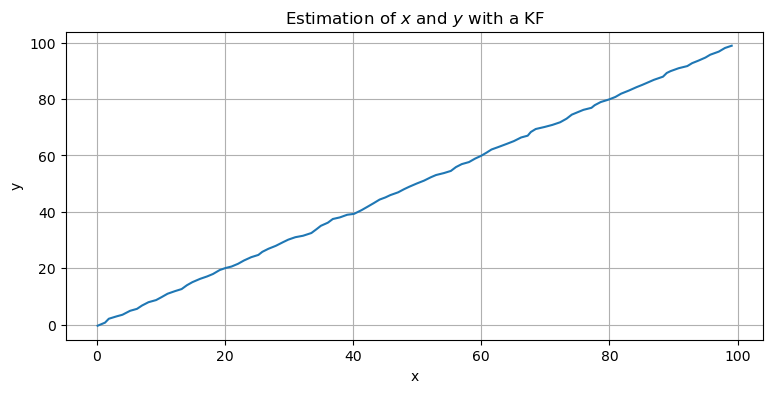

In [12]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.stats import norm

std_x, std_y = 0.3, 0.3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x ** 2, std_y ** 2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt = 1, var = 0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt = 1, var = 0.02)

zs = [np.array([norm.rvs(loc = i, scale = std_x, size = 1), 
                norm.rvs(loc = i, scale = std_y, size = 1)]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Estimation of $x$ and $y$ with a KF')
plt.show()

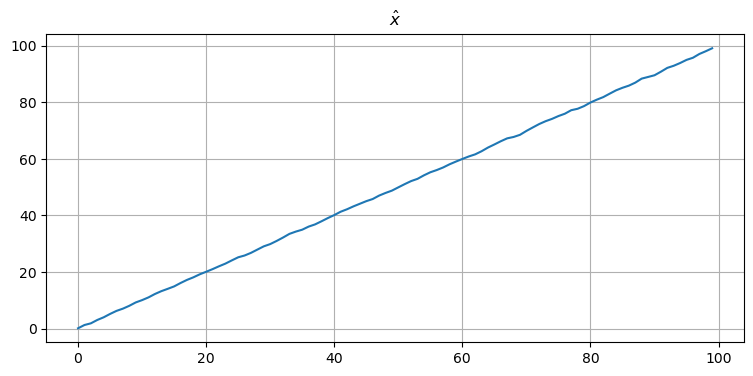

In [13]:
plt.plot(xs[:, 0])
plt.title('$\hat{x}$')
plt.show()

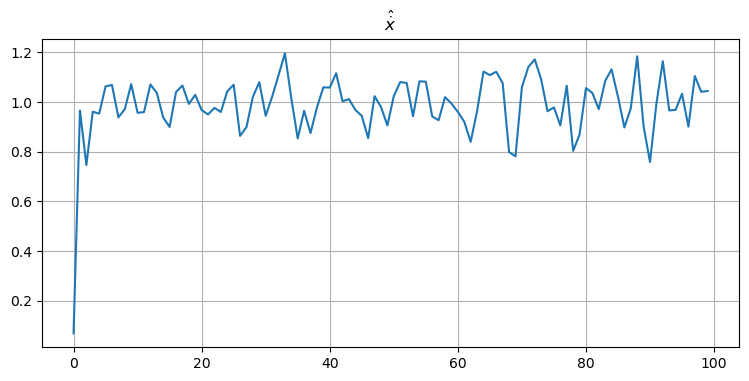

In [14]:
plt.plot(xs[:, 1])
plt.title('$\hat{\dot{x}}$')
plt.show()
plt.show()

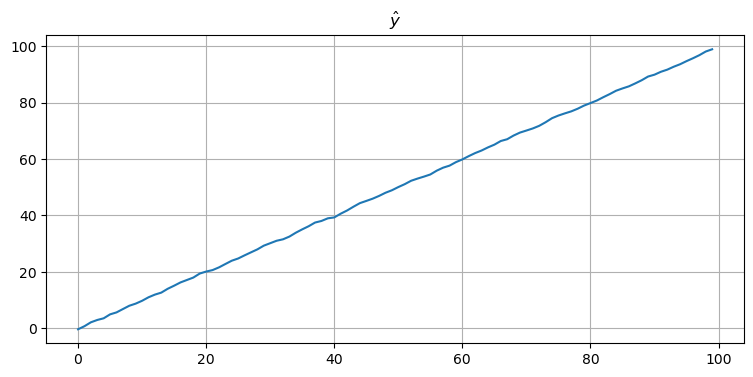

In [15]:
plt.plot(xs[:, 2])
plt.title('$\hat{y}$')
plt.show()

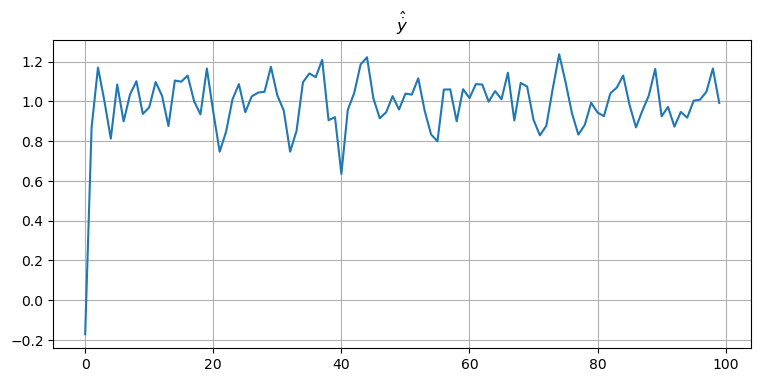

In [16]:
plt.plot(xs[:, 3])
plt.title('$\hat{\dot{y}}$')
plt.show()

We are going to implement an Unscented Kalman Filter (UKF) to solve the same problem although this is not useful given the linear nature of the model. This is just to illustrate the construction of the filter in the context of the _FilterPy_ library. 

In [17]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity model"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

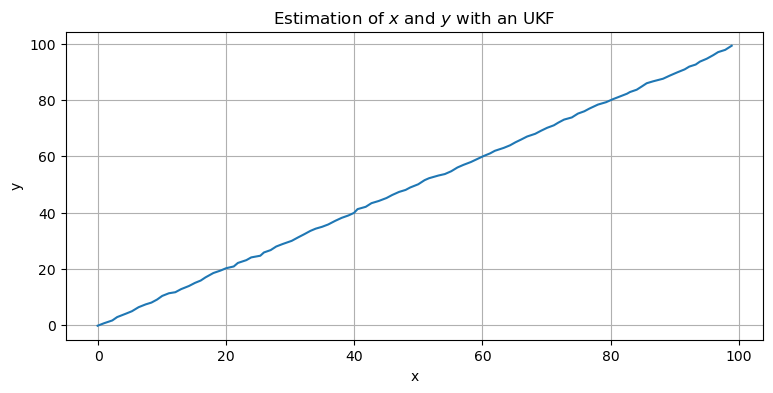

In [18]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise

import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

std_x, std_y = 0.3, 0.3
dt = 1.0
sigmaPoints = MerweScaledSigmaPoints(4, alpha = 0.1, beta = 2.0, kappa = 1.0)
ukf = UKF(dim_x = 4, dim_z = 2, fx = f_cv, hx = h_cv, dt = dt, points = sigmaPoints)
ukf.x = np.array([0.0, 0.0, 0.0, 0.0])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt = 1, var = 0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt = 1, var = 0.02)

#zs = [np.array([norm.rvs(loc = i, scale = std_x, size = 1), 
#                norm.rvs(loc = i, scale = std_y, size = 1)]) for i in range(100)]

zs = [np.array([i + randn() * std_x, 
                i + randn() * std_y]) for i in range(100)]  

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Estimation of $x$ and $y$ with an UKF')
plt.show()
#print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

### Study the example below


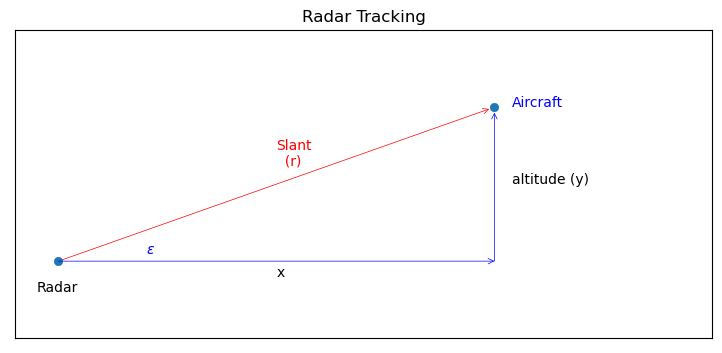

In [19]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

The *elevation angle* $\epsilon$ is the angle above the line of sight formed by the ground.

We assume that the aircraft is flying at a constant altitude. The state vector is:

$$
\mathbf{x} = \begin{bmatrix}
                x \\
                \dot{x} \\
                y
             \end{bmatrix}
$$

with $x$ the distance, $\dot{x}$ the velocity and $y$ the altitude.

The matrix $\mathbf{F}$ is:

$$
\mathbf{x}_{k+1} = \begin{bmatrix}
                        1 & \Delta t & 0 \\
                        0 & 1 & 0 \\
                        0 & 0 & 1
                   \end{bmatrix}
                   \mathbf{x}_{k}
$$

The computation of $\mathbf{F}$ can be implemented with the following function:

In [20]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

The measurement function $\mathbf{H}$.

$$
    \begin{bmatrix}
        r \\
        \epsilon
    \end{bmatrix}
    =
    \mathbf{H} \begin{bmatrix}
                x \\
                \dot{x} \\
                y
             \end{bmatrix}
$$

$$
    r = \sqrt{(x_\text{aircraft} - x_\text{radar})^2 + (y_\text{aircraft} - y_\text{radar})^2}
$$

$$
    \epsilon = \tan^{-1} \frac{y}{x}
$$

$$
    \epsilon = \tan^{-1}{\frac{y_\text{aircraft} - y_\text{radar}}{x_\text{aircraft} - x_\text{radar}}}
$$

The computation of $\mathbf{H}$ can be implemented with the following function:

In [21]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx ** 2 + dy ** 2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

The simulation of the aircraft and the radar are carried out by the following code:

In [22]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng = rng + randn() * self.range_std
        brg = brg + randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel * dt + (randn() * self.vel_std) * dt      
        self.pos = self.pos + dx     
        return self.pos

UKF implementation for aircraft tracking. 

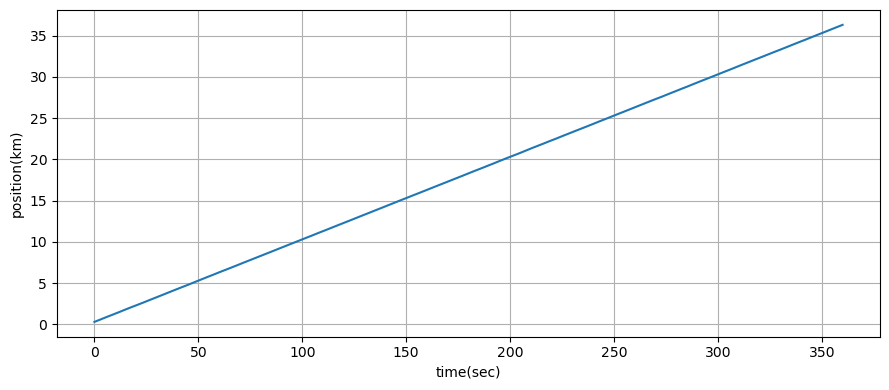

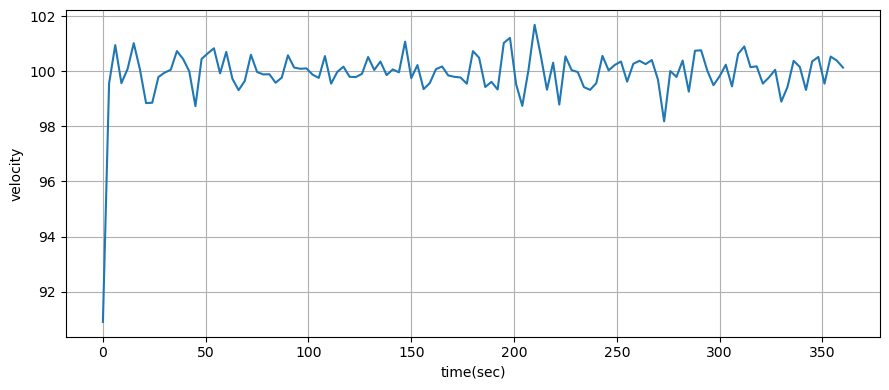

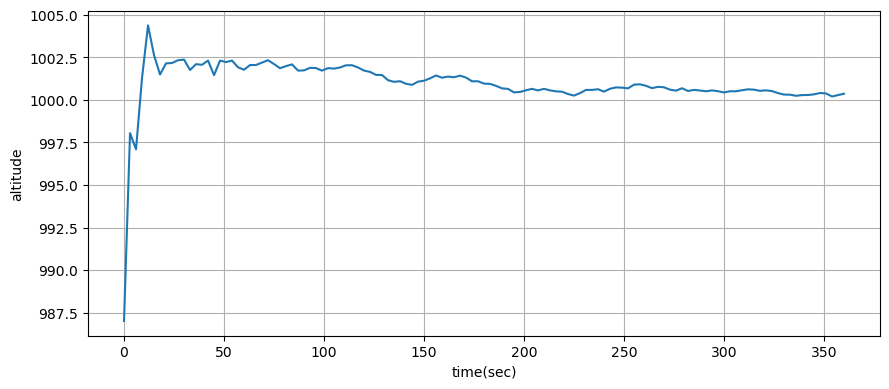

In [23]:
import math
from kf_book.ukf_internal import plot_radar

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, elevation_angle_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)    
plot_radar(xs, time)